In [142]:
import re
import pandas as pd
import seaborn as sns
import nltk
from textblob import TextBlob
# import chartify
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/6ones/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/6ones/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [116]:
sns.set_theme(style='darkgrid', context="notebook");
sns.despine();

<Figure size 432x288 with 0 Axes>

In [37]:
def clean_tweet(text): 
    """ 
    Use sumple regex statemnents to clean tweet text by removing links and special characters
    """
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) \
                                |(\w+:\/\/\S+)", " ", text).split()) 

def de_emojify(text):
    """
    Strip all non-ASCII characters to remove emoji characters
    """
    if text:
        return text.encode('ascii', 'ignore').decode('ascii')
    else:
        return None

In [113]:
def load_data(file_location):
    df = pd.read_csv(file_location,
                     index_col=False,
                     names=[
                            'id', 'id_str', 'created_at', 'user_screen_name', 'text', 'source', \
                            'reply_count', 'retweet_count', 'favourite_count', 'retweeted', \
                            'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', \
                            'is_quote_status', 'user_name', 'user_id_str', 'user_location', 'user_verified', 'user_followers_count', \
                            'user_friends_count', 'user_protected', 'user_created_at', 'user_description', 'user_favourites_count', \
                            'user_statuses_count', 'url', 'media', 'urls'
                        ])
    return df



def clean_data(df):
    df = df.drop(['id_str'], axis=1)
    df = df.drop_duplicates()
    df = df.set_index('id')
    df['text'] = df['text'].apply(de_emojify)
    df['text'] = df['text'].apply(clean_tweet)    
    return df


def drop_cols(df, cols):
    """Drop columns"""
    df = df.drop(cols, axis='columns')
    return df

def to_datetime(df, cols):
    """Convert date columns to pandas datetime"""
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

In [96]:
df = load_data('./data/livongo.csv')

columns_to_drop = ['user_id_str','in_reply_to_status_id_str','in_reply_to_user_id_str','in_reply_to_screen_name','user_description']
date_columns = ['user_created_at','created_at']

df = (df
      .pipe(clean_data)
      .pipe(drop_cols, columns_to_drop)
      .pipe(to_datetime, date_columns))

## Analysis on Tweets

### 1. Sentiment Analysis

In [153]:
def analyze_sentiment(df):
    """Analyze sentiment using the text column"""
    df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment)
    df['polarity'] = df['sentiment_score'].apply(lambda x: x[0])
    df['subjectivity'] = df['sentiment_score'].apply(lambda x: x[1])
    df = df.drop('sentiment_score', axis='columns')
    df['sentiment'] = pd.cut(df.polarity, 3,labels=['negative','neutral','positive'])
    return df
   
df = df.pipe(analyze_sentiment)

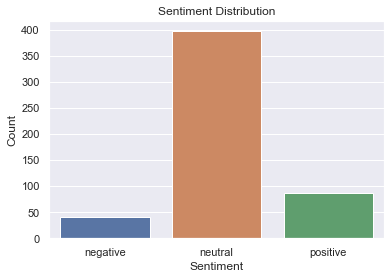

In [152]:
sns.countplot(x='sentiment', data=df)

plt.title('Sentiment Distribution');
plt.xlabel('Sentiment')
plt.ylabel('Count');

In [166]:
negatives = df.loc[df.sentiment == 'negative'][['sentiment','polarity','text']]
one = negatives.iloc[0]

one.text, one.polarity

('Guidewell | Livongo Signs Strategic Partnership with GuideWell Accelerating Care Delivery to Vulnerable Populations #GuideWellNow',
 -0.5)

### 2. Text Analysis